In [1]:
import torch
from torch import nn
import torchvision
from torchvision import transforms
from torchvision.transforms import ToTensor, Pad
import matplotlib.pyplot as plt

In [2]:
class MyVAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            # (conv_in)
            nn.Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), # 28, 28
            
            # (down_block_0)
            # (norm1)
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            # (conv1)
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (norm2): 
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            # (dropout): 
            nn.Dropout(p=0.5, inplace=False),
            # (conv2): 
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (nonlinearity): 
            nn.SiLU(),
            # (downsamplers)(conv): 
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), #14, 14


            
            # (down_block_1)
            # (norm1)
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            # (conv1)
            nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (norm2): 
            nn.GroupNorm(8, 64, eps=1e-06, affine=True),
            # (dropout): 
            nn.Dropout(p=0.5, inplace=False),
            # (conv2): 
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (nonlinearity): 
            nn.SiLU(),
            # (conv_shortcut): 
            #nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)), #28, 28
            # (nonlinearity): 
            nn.SiLU(),            
            # (downsamplers)(conv): 
            nn.Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1)), #7, 7

            # (conv_norm_out): 
            nn.GroupNorm(16, 64, eps=1e-06, affine=True),
            # (conv_act): 
            nn.SiLU(),
            # (conv_out): 
            nn.Conv2d(64, 3, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

            #nn.Conv2d(1, 4, kernel_size=3, stride=2, padding=3//2), # 14*14
            #nn.ReLU(),
            #nn.Conv2d(4, 8, kernel_size=3, stride=2, padding=3//2), # 7*7    
            #nn.ReLU(),
        )

        self.decoder = nn.Sequential(
            #(conv_in): 
            nn.Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),

            #(norm1): 
            nn.GroupNorm(16, 64, eps=1e-06, affine=True),
            #(conv1): 
            nn.Conv2d(64, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #(norm2): 
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            #(dropout): 
            nn.Dropout(p=0.5, inplace=False),
            #(conv2): 
            nn.Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #(nonlinearity): 
            nn.SiLU(),      

            #(upsamplers): 
            nn.Upsample(scale_factor=2, mode='nearest'), # 14,14

            #(norm1): 
            nn.GroupNorm(8, 32, eps=1e-06, affine=True),
            #(conv1): 
            nn.Conv2d(32, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #(norm2): 
            nn.GroupNorm(8, 16, eps=1e-06, affine=True),
            #(dropout): 
            nn.Dropout(p=0.5, inplace=False),
            #(conv2): 
            nn.Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
            #(nonlinearity): 
            nn.SiLU(),      

            #(upsamplers): 
            nn.Upsample(scale_factor=2, mode='nearest'),  # 16, 28, 28          

            #(norm1): 
            nn.GroupNorm(8, 16, eps=1e-06, affine=True),
            #(conv1): 
            nn.Conv2d(16, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),  

            nn.Sigmoid()
        )
        
    def forward(self, xb, yb):
        x = self.encoder(xb)
        #print("current:",x.shape)
        x = self.decoder(x)
        #print("current decoder:",x.shape)
        #x = x.flatten(start_dim=1).mean(dim=1, keepdim=True)
        #print(x.shape, xb.shape)
        return x, F.mse_loss(x, xb)

In [3]:
class MyCLIP(nn.Module):
    def __init__(self, n_classes, emb_dim, img_encoder):
        super().__init__()
        self.n_classes = n_classes
        self.emb_dim = emb_dim
        self.text_encoder = nn.Embedding(self.n_classes, self.emb_dim)
        self.img_encoder = img_encoder
    
    def forward(self, img, label):
        img_bs = img.shape[0]
        text_emb = self.text_encoder(label)
        img_emb = self.img_encoder(img).view(img_bs, -1)
        logits = text_emb @ (img_emb.T)
        return logits

In [4]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
emb_dim = 192
batch_size = 32

In [5]:
device = "cuda"

myVAE = MyVAE().to(device)
clip = MyCLIP(n_classes = len(labels_map), emb_dim = emb_dim, img_encoder = myVAE.encoder).to(device)

In [6]:
fashion_data_train = torchvision.datasets.FashionMNIST(root='./data/', train=True, download=True, transform=transforms.Compose([Pad([2,2,2,2]), ToTensor()]))
fashion_data_test = torchvision.datasets.FashionMNIST(root='./data/', train=False, download=True, transform=transforms.Compose([Pad([2,2,2,2]), ToTensor()]))

In [20]:
dl_train = torch.utils.data.DataLoader(fashion_data_train, batch_size=batch_size, shuffle=True, num_workers=4)
dl_test = torch.utils.data.DataLoader(fashion_data_test, batch_size=batch_size*4, shuffle=True, num_workers=4)

In [8]:
train_x, train_y = next(iter(dl_train))

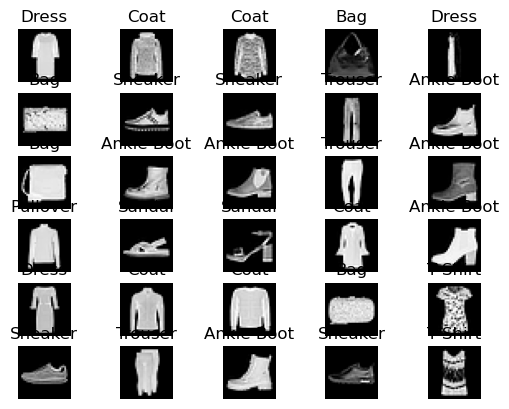

In [9]:
def show_batch(train_x, train_y):
    figure = plt.figure()
    col = 5
    row = train_x.shape[0]//col
    for i in range(row*col):
        idx = i
        img = train_x[idx]
        label = train_y[idx].item()
        figure.add_subplot(row, col, i+1)
        plt.title(labels_map[label])
        plt.axis("off")
        plt.imshow(img.squeeze(), cmap="gray")
show_batch(train_x, train_y)

In [10]:
device

'cuda'

In [11]:
myVAE.encoder(train_x.to(device)).shape

torch.Size([32, 3, 8, 8])

In [12]:
clip.eval()
clip.to(device)
clip(train_x.to(device), train_y.to(device))

tensor([[-11.4883,  -8.9794,  -8.8108,  ...,  -4.3257,  -4.0473,  -6.4487],
        [  5.3306,   4.9514,   3.0720,  ...,   7.0517,   7.1697,   2.5863],
        [  5.3306,   4.9514,   3.0720,  ...,   7.0517,   7.1697,   2.5863],
        ...,
        [  0.0432,  -1.0923,   0.9900,  ...,   3.5742,  -6.1654,  -4.1955],
        [ -4.0519,   5.0547,   1.7506,  ...,   1.5054,   6.9518,   7.4620],
        [ -4.0519,   5.0547,   1.7506,  ...,   1.5054,   6.9518,   7.4620]],
       device='cuda:0', grad_fn=<MmBackward0>)

In [13]:
clip(train_x.to(device), train_y.to(device)).diagonal()

tensor([-11.4883,   4.9514,   3.0720,  -3.1252,  -6.6921,  -4.8976,   0.2542,
          0.4713,  -4.0333,  10.2035,  -8.8491,   8.4076,  10.4899,  -0.6715,
          0.8946,   1.4250,   7.6691,   5.4250,   5.9307,   2.3775,  -7.1254,
          6.9983,  -4.0057,  -2.4371,  -4.1538,   5.0551,  -8.1671,   5.6679,
          4.1982,   3.5742,   6.9518,   7.4620], device='cuda:0',
       grad_fn=<DiagonalBackward0>)

In [23]:
lr = 1e-4
adam_beta1 = 0.95
adam_beta2 = 0.999
adam_weight_decay = 1e-6
adam_epsilon = 1e-08

optimizer = torch.optim.AdamW(
    clip.parameters(),
    lr=lr,
    betas=(adam_beta1, adam_beta2),
    weight_decay=adam_weight_decay,
    eps=adam_epsilon,
)

def train():
    step = 0
    losses = 0
    for train_x, train_y in dl_train:
        clip.train()
        #x_train - 0.5
        logits = clip(train_x.to(device),train_y.to(device))
        ground_truth = torch.arange(batch_size).to(device)
        loss_fn = torch.nn.CrossEntropyLoss().to(device)
        loss1 = loss_fn(logits, ground_truth)
        loss2 = loss_fn(logits.T, ground_truth)
        loss = (loss1 + loss2)/2
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        #lr_scheduler.step()
        
        losses += loss
        
        if step % 100 == 99:
            
            print(f'loss: {losses/100}')
            losses = 0
            clip.eval()
            #rand_idx = torch.randint(0,len(dl_test), (batch_size,))
            eval_x, eval_y = next(iter(dl_test))
            #logits = clip(eval_x.to(device),eval_y.to(device))
            logits = clip(eval_x.to(device),torch.arange(len(labels_map)).to(device))
            probability = torch.nn.functional.softmax(logits.T, dim=1)
            print(probability.argmax(dim=1))
            accuracy = (probability.argmax(dim=1) == eval_y.to(device)).sum()/eval_y.shape[0]
            print(f"accuracy:{accuracy}")
            
        
        #if step >= 1000:
        #    break
        
        step+=1
        
for _ in range(10):
    train()

loss: 1.656434178352356
tensor([4, 6, 6, 2, 1, 9, 9, 6, 4, 7, 4, 9, 6, 0, 4, 2, 4, 8, 7, 6, 5, 5, 8, 6,
        1, 8, 0, 9, 7, 1, 5, 1, 1, 5, 9, 6, 7, 2, 6, 5, 7, 6, 4, 6, 6, 1, 6, 0,
        5, 4, 0, 6, 9, 1, 2, 5, 5, 8, 2, 3, 8, 3, 2, 2, 0, 6, 7, 8, 2, 4, 9, 5,
        8, 9, 3, 5, 1, 9, 6, 6, 8, 7, 7, 4, 1, 5, 0, 7, 3, 8, 1, 2, 5, 1, 9, 0,
        3, 1, 2, 8, 6, 5, 1, 2, 9, 8, 3, 0, 7, 0, 5, 1, 7, 7, 9, 5, 6, 4, 1, 0,
        9, 5, 7, 5, 7, 6, 5, 7], device='cuda:0')
accuracy:0.8984375
loss: 1.6004738807678223
tensor([4, 7, 6, 6, 7, 6, 2, 9, 2, 7, 9, 3, 7, 5, 6, 9, 3, 1, 8, 7, 0, 5, 6, 2,
        7, 5, 8, 8, 1, 7, 9, 8, 1, 9, 1, 1, 9, 2, 2, 8, 7, 5, 3, 0, 6, 7, 9, 7,
        0, 0, 8, 7, 3, 7, 4, 0, 5, 4, 4, 8, 3, 3, 7, 8, 4, 9, 6, 4, 6, 6, 5, 0,
        6, 0, 9, 4, 3, 6, 2, 9, 2, 7, 5, 9, 4, 1, 4, 7, 6, 3, 6, 4, 8, 9, 1, 6,
        5, 0, 3, 4, 1, 1, 0, 3, 3, 1, 4, 0, 2, 7, 1, 2, 4, 9, 4, 5, 8, 6, 2, 1,
        9, 2, 2, 0, 9, 4, 1, 9], device='cuda:0')
accuracy:0.9296875
loss: 1.58396

In [34]:
torch.save(clip, "myclip.pt")

In [35]:
clip = torch.load("myclip.pt")

In [36]:
eval_x, eval_y = next(iter(dl_test))
logits = clip(eval_x.to(device),torch.arange(len(labels_map)).to(device))
print(logits)

tensor([[ 0.4233, -0.9536,  1.1560,  ..., -1.6572, -3.3995,  0.5577],
        [-1.6363,  6.1791, -4.0029,  ..., -3.4851, -7.9656, -1.5213],
        [ 3.7911, -1.1591,  0.1176,  ...,  2.1375, -1.3286,  2.2446],
        ...,
        [-4.0931, -4.0456, -2.5809,  ..., -6.7330,  6.2228, -4.8445],
        [-0.4874, -1.9975,  6.5487,  ..., -2.8893, -2.3265,  0.6969],
        [-2.3855, -2.5151, -1.3501,  ..., -3.6180,  3.9247, -3.5369]],
       device='cuda:0', grad_fn=<MmBackward0>)


In [37]:
torch.nn.functional.softmax(logits.T, dim=1)

tensor([[3.7614e-03, 4.7958e-04, 1.0913e-01,  ..., 4.1105e-05, 1.5129e-03,
         2.2672e-04],
        [7.9500e-04, 9.9548e-01, 6.4733e-04,  ..., 3.6101e-05, 2.7989e-04,
         1.6680e-04],
        [4.5035e-03, 2.5887e-05, 1.5943e-03,  ..., 1.0731e-04, 9.8991e-01,
         3.6744e-04],
        ...,
        [3.3944e-04, 5.4568e-05, 1.5094e-02,  ..., 2.1202e-06, 9.9007e-05,
         4.7774e-05],
        [6.0116e-05, 6.2513e-07, 4.7685e-04,  ..., 9.0765e-01, 1.7579e-04,
         9.1167e-02],
        [3.4150e-03, 4.2709e-04, 1.8450e-02,  ..., 1.5390e-05, 3.9251e-03,
         5.6902e-05]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

In [38]:
pred = torch.nn.functional.softmax(logits.T, dim=1).argmax(dim=1)
pred

tensor([4, 1, 8, 0, 2, 2, 3, 3, 3, 8, 2, 2, 7, 7, 3, 4, 0, 9, 3, 5, 1, 0, 0, 3,
        2, 1, 0, 5, 0, 2, 3, 1, 5, 4, 0, 0, 7, 5, 3, 0, 9, 5, 2, 5, 2, 1, 2, 5,
        9, 9, 7, 3, 0, 8, 5, 3, 7, 3, 4, 8, 8, 3, 1, 0, 7, 7, 1, 5, 2, 0, 6, 9,
        7, 4, 0, 2, 7, 8, 2, 4, 7, 5, 5, 7, 6, 7, 8, 3, 3, 6, 0, 5, 1, 3, 0, 5,
        2, 0, 4, 3, 2, 0, 6, 7, 3, 5, 8, 9, 5, 5, 4, 8, 7, 7, 0, 9, 4, 3, 9, 2,
        2, 0, 4, 4, 8, 4, 7, 4], device='cuda:0')

In [39]:
eval_y

tensor([4, 1, 8, 0, 6, 2, 3, 3, 3, 8, 2, 2, 7, 7, 3, 4, 0, 9, 3, 5, 1, 0, 0, 3,
        2, 1, 0, 5, 0, 2, 3, 1, 5, 4, 0, 0, 7, 5, 3, 0, 9, 5, 2, 5, 2, 1, 4, 5,
        9, 9, 7, 3, 0, 8, 5, 3, 7, 3, 4, 6, 8, 3, 1, 0, 7, 7, 1, 5, 2, 0, 6, 9,
        7, 4, 0, 2, 7, 8, 2, 0, 7, 5, 5, 7, 3, 7, 8, 3, 4, 6, 0, 5, 1, 3, 0, 5,
        6, 0, 4, 6, 2, 0, 6, 7, 3, 5, 8, 9, 5, 5, 4, 8, 7, 7, 0, 9, 4, 3, 9, 2,
        2, 0, 2, 4, 8, 4, 7, 4])

In [40]:
(torch.nn.functional.softmax(logits.T, dim=1).argmax(dim=1) == eval_y.to(device)).sum()/eval_y.shape[0]

tensor(0.9297, device='cuda:0')

In [41]:
indexes = (torch.nn.functional.softmax(logits.T, dim=1).argmax(dim=1) != eval_y.to(device)).detach().cpu()

In [42]:
indexes

tensor([False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False,  True, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False,  True,
        False, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False,  True, False, False,  True,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False,  True, False, False, False, False, False])

In [43]:
pred[indexes]

tensor([2, 2, 8, 4, 6, 3, 2, 3, 4], device='cuda:0')

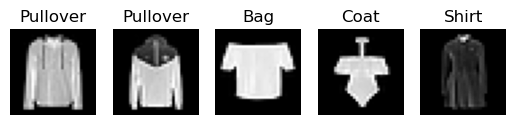

In [44]:
show_batch(eval_x[indexes],pred[indexes])

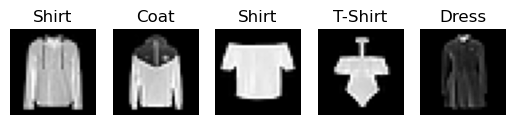

In [45]:
show_batch(eval_x[indexes],eval_y[indexes])